# Sentiment Analysis on Tweets

Dataset used: [tweet_eval dataset (emotion subset)](https://huggingface.co/datasets/cardiffnlp/tweet_eval)

## Imports

In [1]:
import time
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
import html
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
)

In [2]:
import torch

print(torch.cuda.is_available())
torch.cuda.set_device(5)  # if all GPUs are visible and 5 is free
device = torch.device("cuda")

True


In [3]:
import os, sys


print("CONDA_DEFAULT_ENV:", os.environ.get("CONDA_DEFAULT_ENV"))  # env name if set [web:2][web:3]
print("CONDA_PREFIX:", os.environ.get("CONDA_PREFIX"))            # full path to env, if using conda [web:2]
print("Python executable:", sys.executable)                       # path to the python binary [web:2]

print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES"))  # shows current value, e.g. "5" [web:7][web:10][web:16]


CONDA_DEFAULT_ENV: base
CONDA_PREFIX: /usr/local/anaconda3
Python executable: /home/anandvh/.conda/envs/dl_final/bin/python
CUDA_VISIBLE_DEVICES: None


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Loading & Preprocessing Data

### Data loading

In [5]:
ds_train = load_dataset("cardiffnlp/tweet_eval", "emotion", split='train')
ds_test = load_dataset("cardiffnlp/tweet_eval", "emotion", split='test')
ds_val = load_dataset("cardiffnlp/tweet_eval", "emotion", split='validation')

In [6]:
ds_train[0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 2}

### Preprocessing

preprocessing ideas:

Replace common contractions (e.g., "don't" → "do not") to improve tokenization.

Remove special characters and punctuation that don't contribute to emotion.

Normalizing all tweets to lowercase

In [7]:
def lower_text(example):
    example["text"] = str(example["text"]).lower()
    return example

ds_train = ds_train.map(lower_text)
ds_test = ds_test.map(lower_text)
ds_val = ds_val.map(lower_text)

In [8]:
def apply_preprocess(example):
    text = example['text']
    
    new_text = []

    # change all tags to users to "@user" and all links to "http"
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)

    cleaned_text = " ".join(new_text)
    cleaned_text = html.unescape(cleaned_text)

    example['text'] = cleaned_text

    return example
 
ds_train = ds_train.map(apply_preprocess)
ds_val = ds_val.map(apply_preprocess)
ds_test = ds_test.map(apply_preprocess)

### Tokenize the features

The label is already an integer, so only the text (the tweets themselves) needs to be tokenized

In [9]:
ROBERTA_MODEL = "cardiffnlp/twitter-roberta-base"

roberta_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_MODEL, use_fast=False)

def roberta_tokenization(example): return roberta_tokenizer(example['text'], padding='max_length', max_length=128, truncation=True)

#### ROBERTA MODEL

In [10]:
ds_train_tokenized_roberta = ds_train.map(roberta_tokenization, batched=True)
ds_test_tokenized_roberta = ds_test.map(roberta_tokenization, batched=True)
ds_val_tokenized_roberta = ds_val.map(roberta_tokenization, batched=True)

Change format of RoBERTa tokenized datasets into tensors, so that we can use PyTorch

The `input_ids` and `attention_mask` columns will be the actual inputs to the model

In [11]:
ds_train_tokenized_roberta.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
ds_test_tokenized_roberta.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
ds_val_tokenized_roberta.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

ds_train_tokenized_roberta.format # outputting some metadata of the tokenized training set, formatted for pytorch

{'type': 'torch',
 'format_kwargs': {},
 'columns': ['input_ids', 'attention_mask', 'label'],
 'output_all_columns': False}

In [12]:
# 1. Define a filter to find None values
def find_none(example):
    return example['text'] is None

# 2. Apply it to the training set
bad_rows = ds_train.filter(find_none)

print(f"Total rows in train: {len(ds_train)}")
print(f"Rows with None:      {len(bad_rows)}")

Total rows in train: 3257
Rows with None:      0


### Training RoBERTa Model

In [13]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

print("\n" + "="*30)
print(" TRAINING MODEL: RoBERTa")
print("="*30)

model_roberta = AutoModelForSequenceClassification.from_pretrained(ROBERTA_MODEL, num_labels=4)

args_roberta = TrainingArguments(
    output_dir="/data/jiang/anandvh/deep-learning-final-project/results_roberta",
    num_train_epochs=3,              # 3 loops is standard
    per_device_train_batch_size=16,  # Reduce to 8 if you get CUDA OOM error
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",      
    logging_first_step=True, 
    save_total_limit=1,
    learning_rate=1e-4,
    load_best_model_at_end=True,
    weight_decay=0.01,
    report_to="none"                 # Disable wandb logging to keep output clean
)

trainer_roberta = Trainer(
    model=model_roberta,
    args=args_roberta,
    train_dataset=ds_train_tokenized_roberta,
    eval_dataset=ds_val_tokenized_roberta,
    compute_metrics=compute_metrics,
)

trainer_roberta.train()


 TRAINING MODEL: RoBERTa


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.878800,0.514724,0.810160,0.742139,0.759605,0.730270
2,0.474200,0.484498,0.826203,0.753913,0.773986,0.740227
3,0.301000,0.489433,0.834225,0.778351,0.787927,0.771536


/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=78, training_loss=0.557313662308913, metrics={'train_runtime': 39.701, 'train_samples_per_second': 246.114, 'train_steps_per_second': 1.965, 'total_flos': 642726071829504.0, 'train_loss': 0.557313662308913, 'epoch': 3.0})

In [14]:
# Evaluate on validation 
eval_results = trainer_roberta.evaluate()
print(eval_results)


test_results = trainer_roberta.evaluate(ds_test_tokenized_roberta)
print(test_results)
logs = pd.DataFrame(trainer_roberta.state.log_history)


/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.484497994184494, 'eval_accuracy': 0.8262032085561497, 'eval_f1': 0.7539126805628378, 'eval_precision': 0.7739862044513207, 'eval_recall': 0.7402272840098625, 'eval_runtime': 0.2199, 'eval_samples_per_second': 1700.877, 'eval_steps_per_second': 4.548, 'epoch': 3.0}


/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.4778634309768677, 'eval_accuracy': 0.8367346938775511, 'eval_f1': 0.8034491623947629, 'eval_precision': 0.8189434244251865, 'eval_recall': 0.7924419628211987, 'eval_runtime': 0.8968, 'eval_samples_per_second': 1584.505, 'eval_steps_per_second': 3.345, 'epoch': 3.0}


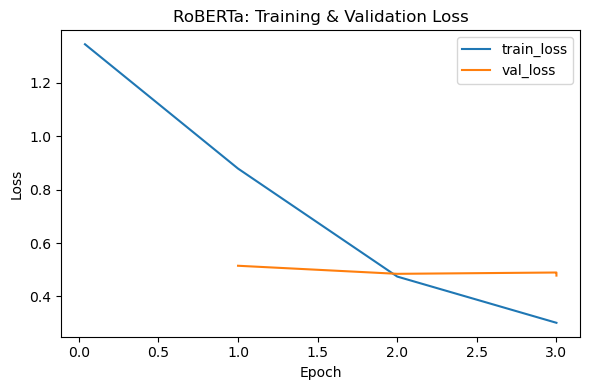

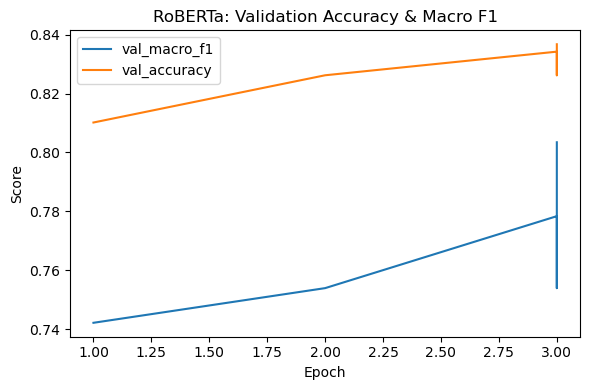

/home/anandvh/.conda/envs/dl_final/lib/python3.11/site-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test classification report:
              precision    recall  f1-score   support

       anger     0.8149    0.9229    0.8655       558
         joy     0.8743    0.8352    0.8543       358
    optimism     0.7027    0.6341    0.6667       123
     sadness     0.8839    0.7775    0.8273       382

    accuracy                         0.8367      1421
   macro avg     0.8189    0.7924    0.8034      1421
weighted avg     0.8387    0.8367    0.8352      1421



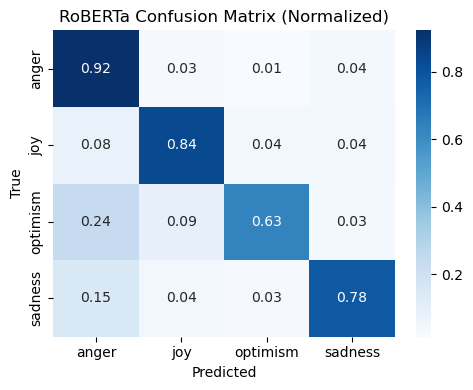

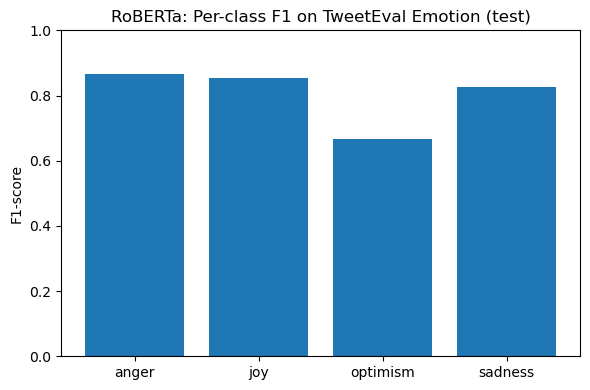

In [16]:
# --------------------
# 6. Training curves
# --------------------
logs = pd.DataFrame(trainer_roberta.state.log_history)

train_logs = logs[logs.get("loss").notnull()][["epoch", "loss"]]
eval_logs  = logs[logs.get("eval_loss").notnull()][
    ["epoch", "eval_loss", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
]

plt.figure(figsize=(6, 4))
plt.plot(train_logs["epoch"], train_logs["loss"], label="train_loss")
plt.plot(eval_logs["epoch"],  eval_logs["eval_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("RoBERTa: Training & Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(eval_logs["epoch"], eval_logs["eval_f1"], label="val_macro_f1")
plt.plot(eval_logs["epoch"], eval_logs["eval_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("RoBERTa: Validation Accuracy & Macro F1")
plt.legend()
plt.tight_layout()
plt.show()

# --------------------
# 7. Final test evaluation
# --------------------
test_pred = trainer_roberta.predict(ds_test_tokenized_roberta)
y_true = test_pred.label_ids
y_pred = np.argmax(test_pred.predictions, axis=-1)

# get label names directly from the dataset
label_names = ds_train.features["label"].names

print("Test classification report:")
print(classification_report(y_true, y_pred, target_names=label_names, digits=4))

# --------------------
# 8. Confusion matrix
# --------------------
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("RoBERTa Confusion Matrix (Normalized)")
plt.tight_layout()
plt.show()

# --------------------
# 9. Per-class F1 bar plot
# --------------------
report = classification_report(
    y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0
)

per_class_f1 = [report[label]["f1-score"] for label in label_names]

plt.figure(figsize=(6, 4))
plt.bar(label_names, per_class_f1)
plt.ylim(0, 1.0)
plt.ylabel("F1-score")
plt.title("RoBERTa: Per-class F1 on TweetEval Emotion (test)")
plt.tight_layout()
plt.show()